In [ ]:
from ray import tune
import ray
import copy
import yaml
import train_and_eval
import glob
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
ray.init(log_to_driver=False)

In [ ]:
def config_helper(config):
    return train_and_eval.run_experiment(**config)

with open('configs/gpn/ood_loc_gpn_16.yaml') as f:
    config = yaml.safe_load(f)

In [ ]:
datasets = ['CoraML', 'CiteSeer', 'PubMed'] #, 'AmazonPhotos', 'AmazonComputers', 'CoauthorCS', 'CoauthorPhysics'

In [ ]:
config['model']['orig_dist_reg'] = tune.grid_search([1.5 ** i for i in range(-40, -0)])
config['model']['dist_reg'] = tune.grid_search([0]) #[10 ** i for i in range(-6, -4)])
config['model']['KNN_K'] = tune.grid_search([1])
config['model']['normalize_dist_reg'] = tune.grid_search([False, ])
config['model']['dist_sigma'] = tune.grid_search([1])
config['model']['dist_embedding_beta'] = tune.grid_search([True, False])
config['data']['dataset'] = tune.grid_search(datasets)
results_orig = tune.run(
    config_helper,
    metric='test_ood_detection_epistemic_auroc',
    mode="max", 
    num_samples=1,
    max_concurrent_trials=16,
    resources_per_trial={"gpu": 1, 'cpu': 8},
    config=config,
    max_failures=10)

In [76]:
df.keys()

Index(['dist_reg', 'KNN_K', 'normalize_dist_reg', 'dist_sigma',
       'dist_embedding_beta', 'val_accuracy',
       'test_ood_detection_epistemic_auroc', 'test_accuracy'],
      dtype='object')

Text(0.5, 0.98, 'Hyper Parameter Results for Tuning Original Graph Distance Reg')

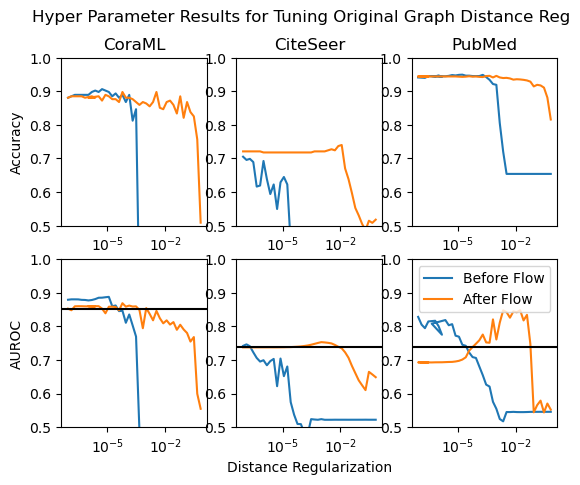

In [85]:
df = results_orig.results_df
flow_df = df[df['config/model/dist_embedding_beta']]
embd_df = df[np.logical_not(df['config/model/dist_embedding_beta'])]
plt.figure()
plt.ylabel("Accuracy")
for i, a_dataset in enumerate(datasets):
    curr_df = flow_df[flow_df['config/data/dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.title(a_dataset)
    if i == 0:  
        plt.ylabel("Accuracy")
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    if i == 0:  
        plt.ylabel("AUROC")
        
    curr_df = embd_df[embd_df['config/data/dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    plt.ylim(0.5, 1)
    if i == 1:
        plt.xlabel("Distance Regularization")
    if a_dataset == 'CoraML':
        bnds = .852
    if a_dataset == 'CiteSeer':
        bnds = .7373
    if a_dataset == 'Pubmed':
        bnds = .6925
    plt.axhline(bnds, c='black')

plt.legend(["Before Flow", "After Flow"])
plt.suptitle("Hyper Parameter Results for Tuning Original Graph Distance Reg")

In [ ]:
config['model']['orig_dist_reg'] = tune.grid_search([0] + [10 ** i for i in range(-6, -3)])
config['model']['dist_reg'] = tune.grid_search([0, 10**-5]) #[10 ** i for i in range(-6, -4)])
config['model']['KNN_K'] = tune.grid_search([1, 2, 5, 25])
config['model']['normalize_dist_reg'] = tune.grid_search([False, ])
config['model']['dist_sigma'] = tune.grid_search([10 ** i for i in range(-1, 3)])
config['model']['dist_embedding_beta'] = tune.grid_search([True, False])
config['data']['dataset'] = tune.grid_search(datasets)
results = tune.run(
    config_helper,
    metric='test_ood_detection_epistemic_auroc',
    mode="max", 
    num_samples=1,
    max_concurrent_trials=16,
    resources_per_trial={"gpu": 1, 'cpu': 8},
    config=config,
    max_failures=10)

In [50]:
df = results.results_df
flow_df = df[df['config/model/dist_embedding_beta']]
embd_df = df[np.logical_not(df['config/model/dist_embedding_beta'])]

plt.figure()
for i, a_dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), i+1)
    curr_df = flow_df[flow_df['config/data/dataset'] == a_dataset]
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    curr_df = embd_df[embd_df['config/data/dataset'] == a_dataset]
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.title(a_dataset)

plt.xlabel("Distance Regularization")

AttributeError: 'list' object has no attribute 'results_df'

In [106]:
param_keys = ['dist_reg', 'orig_dist_reg', 'KNN_K', 'normalize_dist_reg', 'dist_sigma', 'dist_embedding_beta']#, 'config/data/dataset',
result_keys = ['val_accuracy', 'test_ood_detection_epistemic_auroc', 'test_accuracy']
dataset_keys = ['dataset', ]

In [107]:
recent_dirs = sorted(glob.glob("../ray_results/*"))[-2:]
params = []
results = []
for a_recent_dir in recent_dirs:
    params.extend(sorted(glob.glob(a_recent_dir+"/*/params.json")))
    results.extend(sorted(glob.glob(a_recent_dir+"/*/result.json")))

In [108]:
dicts = []
for (a_param, a_result) in zip(params, results):
    with open(a_param) as f:
        a_param_dict = yaml.safe_load(f)
    param_dict = {a_key: a_param_dict['model'][a_key] for a_key in param_keys} | {a_key: a_param_dict['data'][a_key] for a_key in dataset_keys}
    with open(a_result) as f:
        a_result_dict = yaml.safe_load(f)
    # print(a_result_dict.keys())
    try: 
        result_dict = {a_key: a_result_dict[a_key]  for a_key in result_keys}
    except:
        result_dict = dict()
    dicts.append(param_dict | result_dict)

In [109]:
df = pd.DataFrame.from_dict(dicts)

In [110]:
df

,dist_reg,orig_dist_reg,KNN_K,normalize_dist_reg,dist_sigma,dist_embedding_beta,dataset,val_accuracy,test_ood_detection_epistemic_auroc,test_accuracy
0,0,0,1,False,0.1,True,CoraML,0.888889,0.849763,0.885553
1,0,0,1,False,0.1,True,CiteSeer,0.720635,0.737388,0.709812
2,0,0,1,False,0.1,True,PubMed,0.943654,0.692588,0.940923
3,0,0,2,False,0.1,True,CoraML,0.880342,0.852013,0.882739
4,0,0,2,False,0.1,True,CiteSeer,0.720635,0.737388,0.709812
...,...,...,...,...,...,...,...,...,...,...
1003,0,0.666667,1,False,1.0,True,CiteSeer,0.314286,0.521999,0.315240
1004,0,0.666667,1,False,1.0,True,PubMed,0.653618,0.545584,0.653509
1005,0,0.666667,1,False,1.0,False,CoraML,0.508547,0.554573,0.495310
1006,0,0.666667,1,False,1.0,False,CiteSeer,0.517460,0.648579,0.492693


In [113]:
df[df['orig_dist_reg'] == 0]

,dist_reg,orig_dist_reg,KNN_K,normalize_dist_reg,dist_sigma,dist_embedding_beta,dataset,val_accuracy,test_ood_detection_epistemic_auroc,test_accuracy
0,0,0,1,False,0.1,True,CoraML,0.888889,0.849763,0.885553
1,0,0,1,False,0.1,True,CiteSeer,0.720635,0.737388,0.709812
2,0,0,1,False,0.1,True,PubMed,0.943654,0.692588,0.940923
3,0,0,2,False,0.1,True,CoraML,0.880342,0.852013,0.882739
4,0,0,2,False,0.1,True,CiteSeer,0.720635,0.737388,0.709812
...,...,...,...,...,...,...,...,...,...,...
187,1e-05,0,5,False,100.0,False,CiteSeer,0.720635,0.737745,0.710508
188,1e-05,0,5,False,100.0,False,PubMed,0.943061,0.694092,0.941184
189,1e-05,0,25,False,100.0,False,CoraML,0.884615,0.860629,0.882739
190,1e-05,0,25,False,100.0,False,CiteSeer,0.717460,0.739768,0.709116


In [98]:
flow_df.keys()

Index(['dist_reg', 'KNN_K', 'normalize_dist_reg', 'dist_sigma',
       'dist_embedding_beta', 'val_accuracy',
       'test_ood_detection_epistemic_auroc', 'test_accuracy'],
      dtype='object')

Text(0.5, 0.98, 'Hyper Parameter Results for Tuning Original Graph Distance Reg')

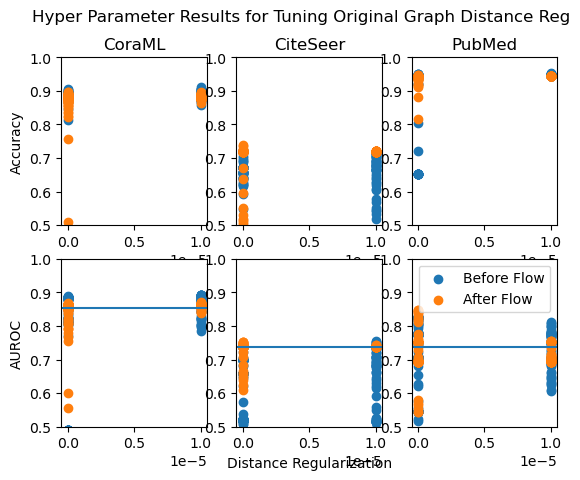

In [103]:
# df = results_orig.results_df
flow_df = df[df['dist_embedding_beta']]
embd_df = df[np.logical_not(df['dist_embedding_beta'])]
plt.figure()
plt.ylabel("Accuracy")
for i, a_dataset in enumerate(datasets):
    curr_df = flow_df[flow_df['dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['val_accuracy'])
    plt.title(a_dataset)
    if i == 0:  
        plt.ylabel("Accuracy")
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    if i == 0:  
        plt.ylabel("AUROC")
        
    curr_df = embd_df[embd_df['dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    plt.ylim(0.5, 1)
    if i == 1:
        plt.xlabel("Distance Regularization")
    if a_dataset == 'CoraML':
        bnds = .852
    if a_dataset == 'CiteSeer':
        bnds = .7373
    if a_dataset == 'Pubmed':
        bnds = .6925
    plt.axhline(bnds)

plt.legend(["Before Flow", "After Flow"])
plt.suptitle("Hyper Parameter Results for Tuning Original Graph Distance Reg")

In [81]:
# dfs = {}
for a_dataset in pd.unique(df["config/data/dataset"]):
    dfs[a_dataset] = df[df["config/data/dataset"] == a_dataset]

KeyError: 'config/data/dataset'

In [ ]:
a_dataset = datasets[7]
dfs[a_dataset]['training_iteration']
# for a_key in dfs[a_dataset].keys():
#     print(a_key)
all_keys = ["config/model/" + a_key for a_key in keys] + ['config/data/dataset', 'val_accuracy', 'test_ood_detection_epistemic_auroc', 'test_accuracy']
dfs[a_dataset][all_keys].sort_values('val_accuracy')

In [ ]:
for a_dataset in datasets:
    curr_df =  dfs[a_dataset][all_keys]
    print(a_dataset)
    for i, KNN_K in enumerate(pd.unique(curr_df['config/model/KNN_K'])):
        K_df = curr_df[curr_df['config/model/KNN_K'] == KNN_K]
        val_selected_test_acc = K_df.iloc[np.argmax(K_df['val_accuracy'])]['test_accuracy']
        val_selected_roc = K_df.iloc[np.argmax(K_df['val_accuracy'])]['test_ood_detection_epistemic_auroc']
        best_roc = K_df.iloc[np.argmax(K_df['test_ood_detection_epistemic_auroc'])]['test_ood_detection_epistemic_auroc']
        print(f"for k={KNN_K} best val selected accuracy {val_selected_test_acc:.4f}, selected ROC: {val_selected_roc:.4f}, best overall {best_roc:.4f}")
        # curr_df[curr_df['config/model/KNN_K'] == KNN_K].plot.scatter(x='config/model/dist_reg', y='config/model/dist_sigma', c='test_ood_detection_epistemic_auroc', logx=True, logy=True, vmin=.8628)
        # plt.title(f"KNN_K = {KNN_K}")
        # plt.show()
    print()